In [1]:
# Diabetic Foot Ulcer Segmentation Inference

In [2]:
from typing import Union, List, Callable
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from pathlib import Path
from PIL.Image import Image
import torchvision
import git

from fastai.data.block import DataBlock
from fastai.data.core import DataLoaders
from fastai.layers import Mish
from fastai.learner import Learner
from fastai.vision.data import ImageBlock
from fastai.vision.data import MaskBlock
from fastai.data.transforms import get_image_files
from fastai.data.transforms import IntToFloatTensor
from fastai.data.transforms import FuncSplitter
from fastai.vision.learner import unet_learner

In [3]:
def download_data():
    git.Git(data_dir).clone("https://github.com/uwm-bigdata/wound-segmentation")

In [4]:
def get_data_dir() -> Path:
    data_dir = Path("../data")

    if not os.path.exists(data_dir):
        os.makedirs(data_dir, exist_ok=True)
    
    if "wound-segmentation" not in os.listdir(data_dir):
        download_data()
        
    dfu_dataset_path = data_dir / "wound-segmentation" / "data" / "Foot Ulcer Segmentation Challenge"
    return dfu_dataset_path

In [5]:
def get_all_data(dfu_dataset_path: str) -> Callable:
    train_path = dfu_dataset_path / "train"
    train_image_path = train_path / "images"
    val_path = dfu_dataset_path / "validation"
    val_image_path = val_path / "images"
    train_images = get_image_files(train_image_path)
    val_images = get_image_files(val_image_path)
    trainval = train_images + val_images
    def all_data(path) -> List[Path]:
        return trainval
    return all_data

In [6]:
def get_datablock(codes: List[str], get_data: Callable) -> DataBlock:
    def is_valid() -> Callable:
        def _func(x): return "/validation/" in str(x)
        def _inner(o, **kwargs): return FuncSplitter(_func)(o)
        return _inner
    
    get_msk = lambda o: o.parent.parent / 'labels' / f'{o.stem}{o.suffix}'

    return DataBlock(
        blocks=(ImageBlock, MaskBlock(codes)),
        get_items=get_data,
        splitter=is_valid(),
        get_y=get_msk,
        batch_tfms=[IntToFloatTensor(div_mask=255)]
    )

In [7]:
def get_dataloader(codes: List[str], datablock: DataBlock) -> DataLoaders:
    datablock = datablock.dataloaders(None, bs=1)
    datablock.vocab = codes
    return datablock

In [8]:
def get_learner(dataloader: DataLoaders, backbone, weights_path: str):
    learner = unet_learner(dataloader, backbone, self_attention=True, act_cls=Mish)
    learner.load(weights_path)
    return learner

In [9]:
def predict(image_path, learner) -> np.ndarray:
    dl = learner.dls.test_dl([image_path])
    preds = learner.get_preds(dl=dl)
    pred = preds[0][0]
    pred_arx = pred.argmax(dim=0)
    image = (pred_arx.numpy() * 255).astype(np.uint8)
    return image

In [10]:
def load_model(weights_path: str, data: Callable) -> Learner:
    codes = ["Void", "Wound"]
    datablock = get_datablock(codes=codes, get_data=data)
    dataloader = get_dataloader(codes=codes, datablock=datablock)
    model = get_learner(dataloader=dataloader, backbone=torchvision.models.resnet.resnet34, weights_path=weights_path)
    return model

In [11]:
def load_image(path: Union[os.PathLike, Image]) -> Image:
    if isinstance(path, Image):
        return path
    elif isinstance(path, os.PathLike):
        img = PIL.Image.open(path)
    else:
        img = PIL.Image.fromarray(path)

    return img.convert("RGBA")

In [12]:
def plot_all(source: Union[str, Image], mask: Image):
    source_img = load_image(source)
    mask_img = load_image(mask)
    combined = PIL.ImageChops.multiply(source_img, mask_img)
    f, axarr = plt.subplots(1,3, figsize=(20,20))
    axarr[0].imshow(source_img)
    axarr[1].imshow(mask_img)
    axarr[2].imshow(combined)
    plt.show()

In [13]:
dfu_dataset_path = get_data_dir()

In [14]:
all_data = get_all_data(dfu_dataset_path=dfu_dataset_path)

In [15]:
model_weights = "dfu-resnet34-two-pass"

In [16]:
model = load_model(weights_path=model_weights, data=all_data)

/Users/madhavajay/.local/share/virtualenvs/fastai-course-2022-0tF2OKzb/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
input_path = Path(dfu_dataset_path) / "test" / "images" / "1014.png"

In [18]:
pred = predict(input_path, model)

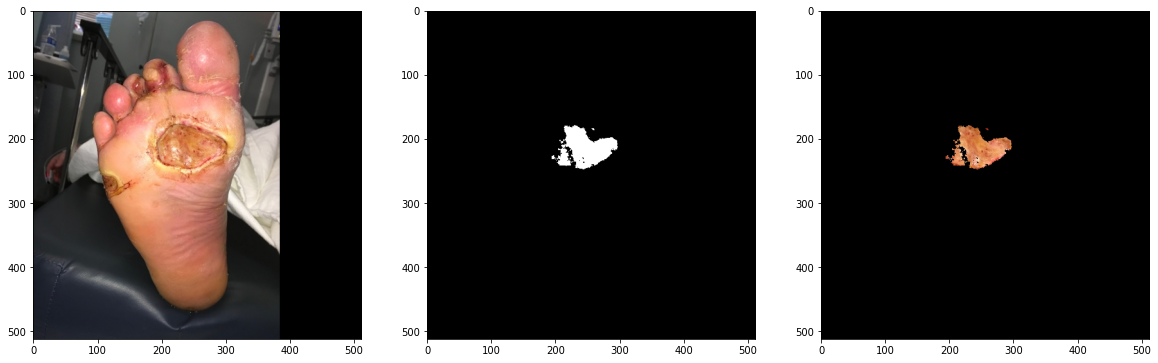

In [19]:
plot_all(input_path, pred)